In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [107]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
org = pd.read_csv('cubic_zirconia.csv')

train = pd.concat([train, org])

ids = test['id']
df = pd.concat([train, test])
df = df.drop(columns = ['id', 'Unnamed: 0'])

In [108]:
df['depth'] = df['depth'].fillna(df.groupby("cut")["depth"].transform('mean'))

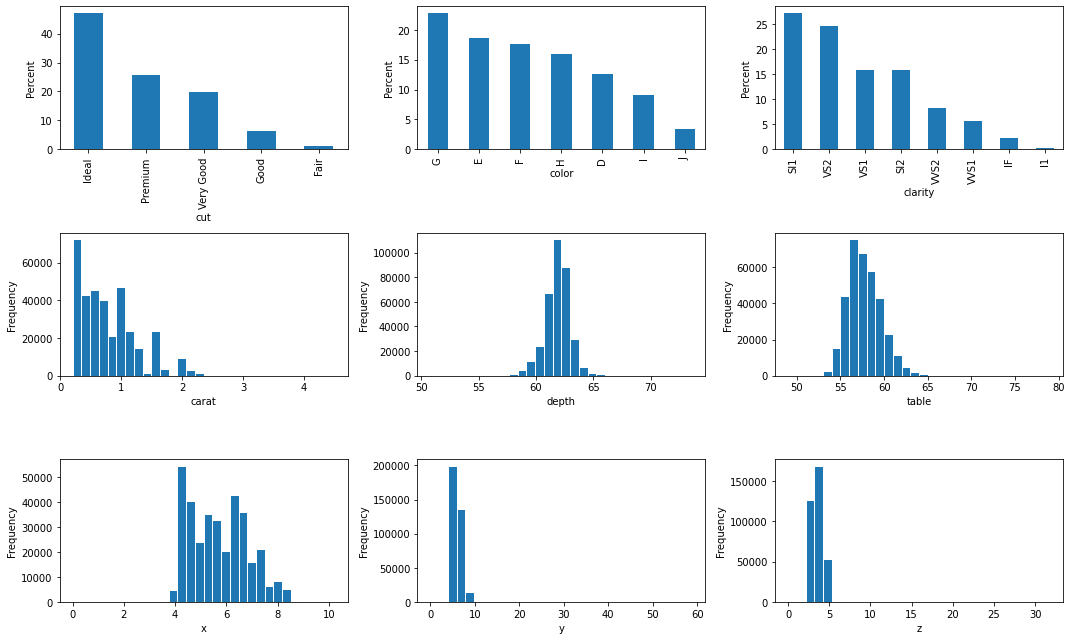

In [109]:
categorical = ['cut', 'color', 'clarity']
numerical = df.drop(columns = categorical).columns[:-1]

fig, axes = plt.subplots(3, 3, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df[col].plot.hist(ax = axes[j], bins = 30, edgecolor='white')
    axes[j].set_xlabel(col)
    
plt.tight_layout()

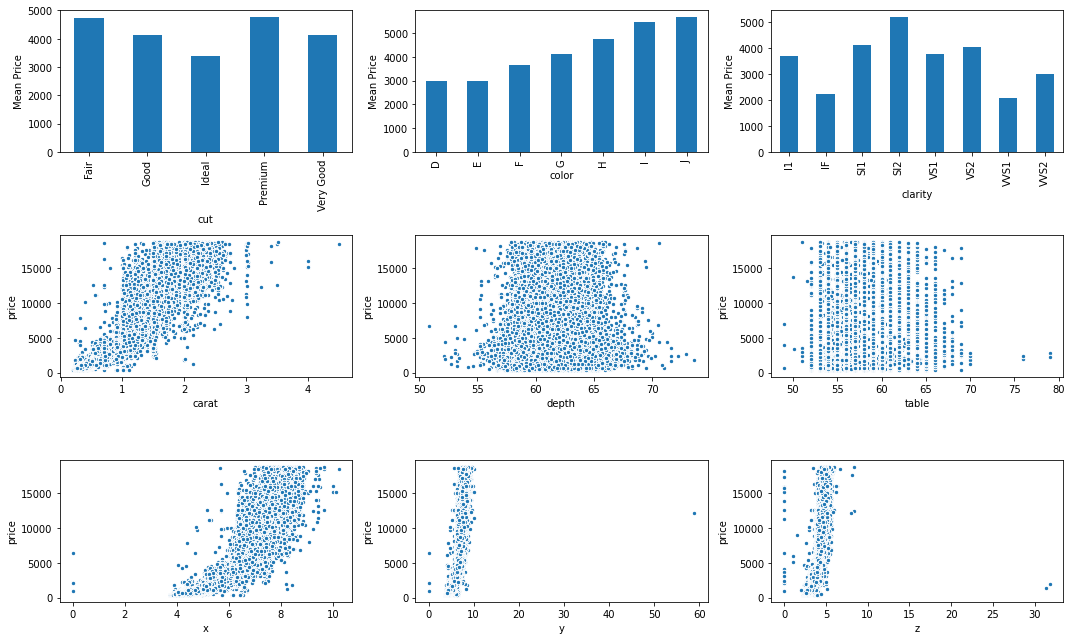

In [110]:
fig, axes = plt.subplots(3, 3, figsize=(15, 9))
axes = axes.flatten()
for i, col in enumerate(categorical):
    df.groupby(col)['price'].mean().plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Mean Price")
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df.plot.scatter(x=col, y='price', ax = axes[j], edgecolor='white')
    axes[j].set_xlabel(col)
    
plt.tight_layout()

In [111]:
cut = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
clarity = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']

cut = dict(zip(cut, range(len(cut))))
clarity = dict(zip(clarity, range(len(clarity)-1, -1, -1)))

df['cut'] = df['cut'].apply(lambda s: cut[s])
df['clarity'] = df['clarity'].apply(lambda s: clarity[s])

In [112]:
df_dummy = pd.get_dummies(df)

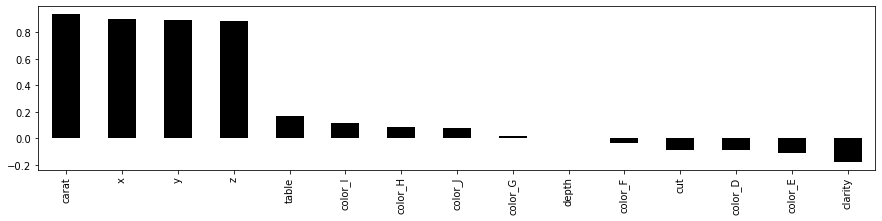

In [113]:
df_dummy.corr()['price'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns='price')
y = df_dummy['price']

features = X.columns.values

Scaler = StandardScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

X_test = X[len(train):]
X = X.iloc[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [115]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

print("Training score: ", model.score(X_train, y_train))
print("Validation score: ", model.score(X_valid, y_valid))

Training score:  0.9352587978888687
Validation score:  0.9347354582704461


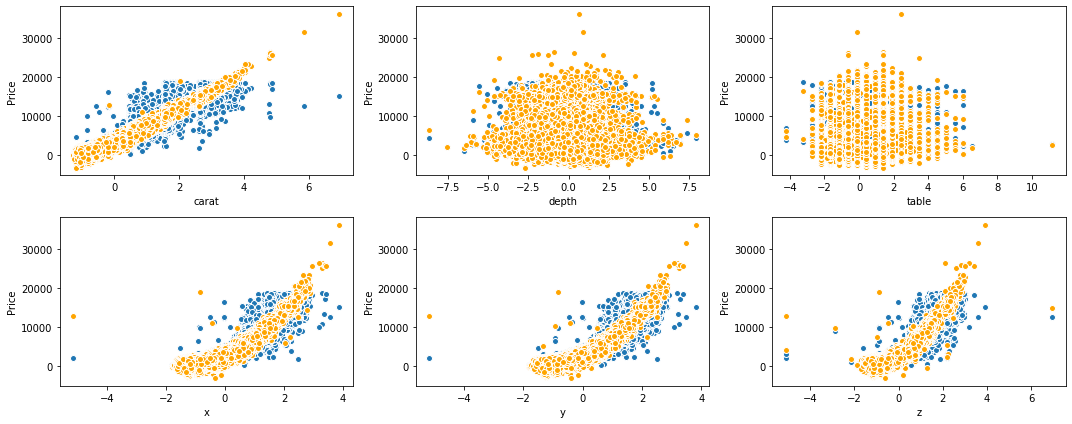

In [116]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for j, col in enumerate(numerical):
    axes[j].scatter(X_valid[col], y_valid, edgecolor='white')
    axes[j].scatter(X_valid[col], model.predict(X_valid), edgecolor='white', color='orange')
    axes[j].set_xlabel(col)
    axes[j].set_ylabel("Price")

plt.tight_layout()

In [117]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

print("Training score: ", model.score(X_train, y_train))
print("Validation score: ", model.score(X_valid, y_valid))

Training score:  0.9844062983370101
Validation score:  0.978471629281319


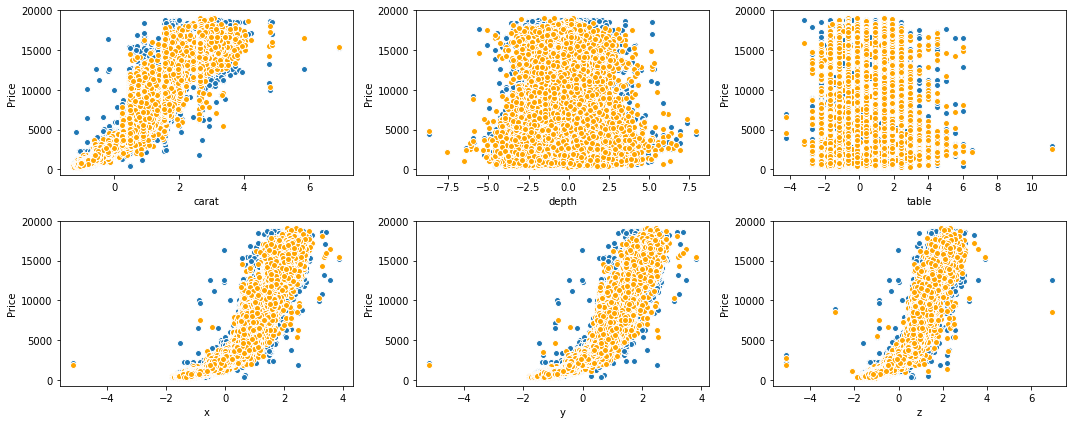

In [118]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for j, col in enumerate(numerical):
    axes[j].scatter(X_valid[col], y_valid, edgecolor='white')
    axes[j].scatter(X_valid[col], model.predict(X_valid), edgecolor='white', color='orange')
    axes[j].set_xlabel(col)
    axes[j].set_ylabel("Price")

plt.tight_layout()

In [119]:
final_model = XGBRegressor()
model.fit(X, y)
print("Training score: ", model.score(X, y))
y_test_pred = model.predict(X_test)

Training score:  0.9833717215444427


In [120]:
output = pd.DataFrame({'id': ids, 'price': y_test_pred})

In [121]:
output.to_csv("Submission.csv", index=False)